# **TMA4215 - Project part 1**

In [168]:
import numpy as np
import matplotlib.pyplot as plt
from functools import reduce
import sympy 
import pandas as pd
from scipy.special import factorial

import tqdm

newparams = {'figure.figsize': (8.0, 6.0), 'axes.grid': True,
             'lines.markersize': 6, 'lines.linewidth': 1,
             'font.size': 10}
plt.rcParams.update(newparams)

## Task *a*

In [169]:
def lagrange_polys(x, xs, ys):
    """
    Evaluates the Lagrange interpolating polynomial as a symbolic expression in x.

    Parameters
    ----------
    x : sympy.Symbol
        The symbolic variable for the polynomial.
    xs : array-like
        The x-coordinates of the known data points.
    ys : array-like
        The y-coordinates of the known data points.

    Returns
    -------
    sympy.Expr
        The symbolic Lagrange interpolating polynomial in x.
    """
    n = len(xs)
    ls = [[reduce(lambda x,y:x*y, [(x - xs[j])/(xs[i] - xs[j]) for j in range(n) if j != i])] for i in range(n)]
    # reduces all the products using lambda function for every i when i!=j
    return reduce(lambda x,y:x+y, np.array(ys)@np.array(ls))
    # sums up all the products of y_i and l_i(x)

In [170]:
def lagrange_func(n, a, b, f, nodes='equidistant'):
    """
    Constructs the Lagrange interpolating polynomial as a callable function.

    Parameters
    ----------
    n : int
        The degree of the polynomial (number of nodes - 1).
    a : float
        The start of the interval.
    b : float
        The end of the interval.
    f : callable
        The function to interpolate.
    nodes : str, optional
        The type of nodes to use ('equidistant' or 'chebyshev'). Default is 'equidistant'.

    Returns
    -------
    tuple
        (nodes used, callable function)
    """
    eq_nodes = np.linspace(-1, 1, n+1)
    cheb_nodes = np.cos((2*np.arange(n+1)+1)/(2*n+2)*np.pi)

    transform_nodes = lambda x: 0.5*(b-a)*x + 0.5*(a+b) # function to transform nodes from [-1,1] to [a,b]
    eq_nodes = transform_nodes(eq_nodes)
    cheb_nodes = transform_nodes(cheb_nodes)

    if nodes == 'equidistant':
        chosen_nodes = eq_nodes
    elif nodes == 'chebyshev':
        chosen_nodes = cheb_nodes
    else:
        raise ValueError("nodes must be 'equidistant' or 'chebyshev'")

    x = sympy.symbols('x') # symbolic variable using sympy

    y_eq = lagrange_polys(x, eq_nodes, f(eq_nodes))
    y_cheb = lagrange_polys(x, cheb_nodes, f(cheb_nodes))

    lagrange_eq_func = sympy.lambdify(x, y_eq, modules=['numpy'])
    lagrange_cheb_func = sympy.lambdify(x, y_cheb, modules=['numpy'])

    if nodes == 'equidistant':
        return eq_nodes, lagrange_eq_func
    else:
        return cheb_nodes, lagrange_cheb_func

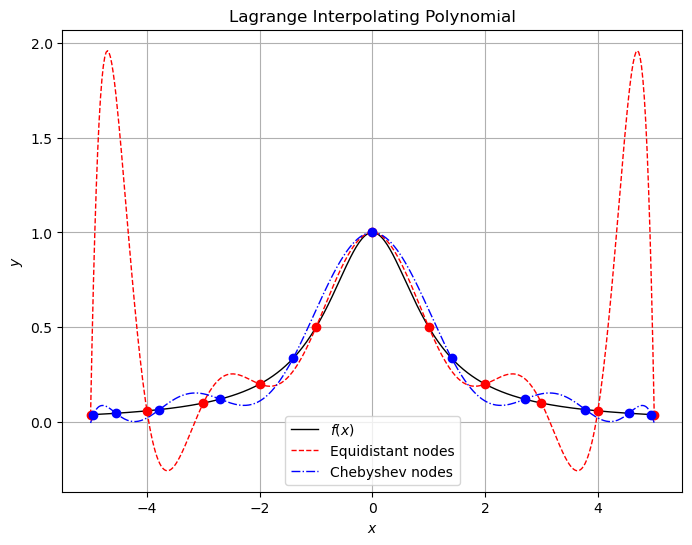

In [171]:
n = 10
a, b = -5, 5

f = lambda x: 1/(1+x**2) # Runge's function
xs = np.linspace(a, b, 400)
ys = f(xs)

eq_nodes, eq_func = lagrange_func(n, a, b, f, nodes='equidistant')
cheb_nodes, cheb_func = lagrange_func(n, a, b, f, nodes='chebyshev')

plt.plot(xs, ys, 'k-', label='$f(x)$')
plt.plot(xs, eq_func(xs), 'r--', label='Equidistant nodes')
plt.plot(xs, cheb_func(xs), 'b-.', label='Chebyshev nodes')
plt.plot(eq_nodes, f(eq_nodes), 'ro')
plt.plot(cheb_nodes, f(cheb_nodes), 'bo')
plt.legend()
plt.xlabel('$x$')
plt.ylabel('$y$')
plt.title('Lagrange Interpolating Polynomial')
plt.show()

The plot shows the Runge function, approximated by two lagrange interpolations polynomials. One with Chebyshev nodes and one with equidistant nodes. Chebyshev nodes results in a much smaller error on the edges of the function, than the equidistant nodes.

## Task *b*

In this task we consider the two functions
$$
f_1(x)=\cos(2\pi x),\quad x\in[0,1],
$$
$$
f_2(x)=e^{3x}\sin(2x),\quad x\in[0,\pi/4].
$$

Furthermore, we estimate $\lVert f - p_n\rVert$, where $\lVert\cdot\rVert$ denotes either the max-norm ($L^\infty$) or the $L^2$-norm on $[a,b]$, for various values of $n$. We approximate these norms using a uniform evaluation grid $\{\eta_i\}_{i=0}^{N}$ on $[a,b]$ with step $h=(b-a)/N$ (we take $N=100\,n$, so there are $N{+}1$ sample points). The discrete estimates are
$$
\lVert f - p_n\rVert_{\infty}\ \approx\ \max_{0\le i\le N}\, \bigl|f(\eta_i)-p_n(\eta_i)\bigr|,
$$
$$
\lVert f - p_n\rVert_{2}\ \approx\ \Bigl(h\sum_{i=0}^{N} \bigl(f(\eta_i)-p_n(\eta_i)\bigr)^2\Bigr)^{1/2}
\ =\ \frac{\sqrt{b-a}}{\sqrt{N}}\,
\left(\sum_{i=0}^{N} \bigl(f(\eta_i)-p_n(\eta_i)\bigr)^2\right)^{1/2}.
$$

We also compare the numerical results for $f_1$ on $[0,1]$ with a theoretical error bound. Assume $f\in C^{n+1}[a,b]$, let distinct nodes $x_0,\dots,x_n\in[a,b]$, and let $p_n$ be the degree-$n$ interpolating polynomial of $f$ at these nodes. Then for each $x\in[a,b]$ there exists $\xi=\xi(x)\in(a,b)$ such that
$$
f(x)-p_n(x)=\frac{f^{(n+1)}(\xi(x))}{(n+1)!}\,\prod_{j=0}^{n}(x-x_j).
$$
Define the nodal polynomial
$$
\omega_{n+1}(x)=\prod_{j=0}^{n}(x-x_j),
$$
and set
$$
M_{n+1}=\max_{\xi\in[a,b]}\bigl|f^{(n+1)}(\xi)\bigr|.
$$
Then
$$
\max_{x\in[a,b]}\bigl|f(x)-p_n(x)\bigr|
\ \le\ \frac{M_{n+1}}{(n+1)!}\,\max_{x\in[a,b]}\bigl|\omega_{n+1}(x)\bigr|.
$$

For $f(x)=\cos(2\pi x)$ and any integer $k\ge 0$,
$$
f^{(k)}(x)=(2\pi)^k\cos\!\left(2\pi x+\frac{k\pi}{2}\right),
\qquad
\lVert f^{(k)}\rVert_{\infty}=(2\pi)^k\ \text{on}\ [0,1].
$$
Using $|x-x_j|\le 1$ for $x,x_j\in[0,1]$ gives the crude, node-independent bound
$$
\lVert f-p_n\rVert_{\infty}
\le
\frac{\lVert f^{(n+1)}\rVert_{\infty}}{(n+1)!}\,\max_{x\in[0,1]}\bigl|\omega_{n+1}(x)\bigr|
\le
\frac{(2\pi)^{n+1}}{(n+1)!}.
$$
Thus, for any node set in $[0,1]$,
$$
\lVert f-p_n\rVert_{\infty}\ \le\ \frac{(2\pi)^{n+1}}{(n+1)!}.
$$

*Note*, we can apply a similar argument to  $f_2$ to rach a similar bound on the form $\frac{(C)^{n+1}}{(n+1)!}$ with a constant $C\ge0$. That is $\lim_{n \to \infty} \lVert f-p_n\rVert_{\infty} = \lim_{n \to \infty}\frac{(C)^{n+1}}{(n+1)!} = 0$ for both $f_1$ and $f_2$, meaning the interpolation polynomial converges regardless of nodes.


We can improve the bound by taking Chebyshev nodes mapped to $[0,1]$. Let $t_0,\dots,t_n$ be the $n{+}1$ zeros of $T_{n+1}$ on $[-1,1]$. Then
$$
\prod_{j=0}^{n}(t-t_j)=2^{-n}T_{n+1}(t),\qquad |T_{n+1}(t)|\le 1\ \text{for }t\in[-1,1].
$$
Mapping $[-1,1]\to[0,1]$ via $x=\tfrac{t+1}{2}$ gives $x_j=\tfrac{t_j+1}{2}$ and
$$
\omega_{n+1}(x)=\prod_{j=0}^{n}(x-x_j)
=\prod_{j=0}^{n}\frac{t-t_j}{2}
=2^{-(n+1)}\prod_{j=0}^{n}(t-t_j)
=2^{-(2n+1)}\,T_{n+1}(t).
$$
Therefore,
$$
\max_{x\in[0,1]}\bigl|\omega_{n+1}(x)\bigr|\ \le\ 2^{-(2n+1)}.
$$
Plugging into the remainder bound with $\lVert f^{(n+1)}\rVert_{\infty}=(2\pi)^{n+1}$ yields
$$
\lVert f-p_n\rVert_{\infty} \le \frac{(2\pi)^{n+1}}{(n+1)!}\,2^{-(2n+1)} = \boxed{ \frac{\pi^{\,n+1}}{2^{\,n}(n+1)!}}.
$$

In [172]:
n_values = np.logspace(1, 6, 6, base=2, dtype=int)
a, b = 0, 1 # interval
f_1 = lambda x: np.cos(2*np.pi*x) # function to interpolate
errors_f1 = []
for n in tqdm.tqdm(n_values): # tqdm for progress bar
    N = 100*n
    cheb_nodes, cheb_func = lagrange_func(n, a, b, f_1, nodes='chebyshev') # nodes and function for Chebyshev
    xs = np.linspace(a, b, N) # evaluation points
    f_vals = f_1(xs)            # true function values
    cheb_vals = cheb_func(xs) # interpolated values

    err_max = np.max(np.abs(f_vals - cheb_vals)) # max norm error
    err_2 = np.sqrt((b-a)/N) * np.sqrt(np.sum((f_vals - cheb_vals)**2)) # 2-norm error
    errors_f1.append((err_max, err_2))
errors_f1 = np.array(errors_f1)

100%|██████████| 6/6 [00:06<00:00,  1.05s/it]


In [185]:
err_bnd = lambda n: (np.power(np.pi, n+1)/(2**(n)*factorial(n+1)))
err_bnd_values = err_bnd(n_values)

In [177]:
a, b = 0, np.pi/4 # interval
f_2 = lambda x: np.exp(3*x)*np.sin(2*np.pi*x) # function to interpolate
errors_f2 = []
for n in tqdm.tqdm(n_values): # tqdm for progress bar
    N = 100*n
    cheb_nodes, cheb_func = lagrange_func(n, a, b, f_2, nodes='chebyshev') # nodes and function for Chebyshev
    xs = np.linspace(a, b, N) # evaluation points
    f_vals = f_2(xs)          # true function values
    cheb_vals = cheb_func(xs) # interpolated values

    err_max = np.max(np.abs(f_vals - cheb_vals)) # max norm error
    err_2 = np.sqrt((b-a)/N) * np.sqrt(np.sum((f_vals - cheb_vals)**2)) # 2-norm error
    errors_f2.append((err_max, err_2))
errors_f2 = np.array(errors_f2)

100%|██████████| 6/6 [00:06<00:00,  1.10s/it]


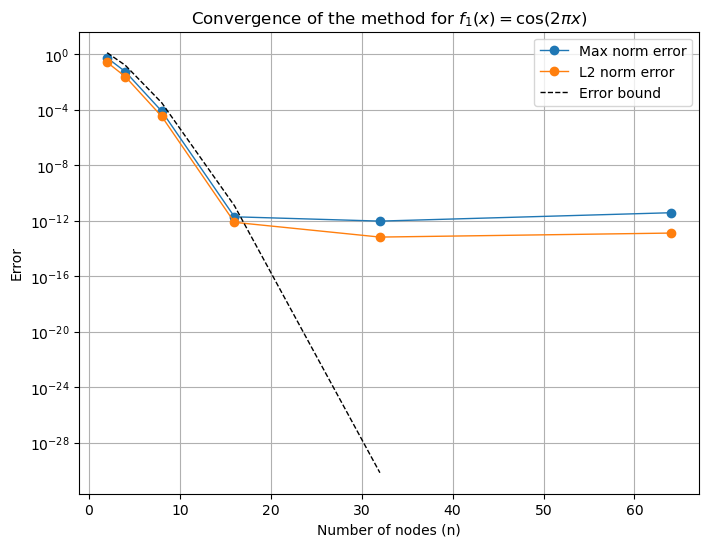

In [186]:
plt.semilogy(n_values, errors_f1[:, 0], 'o-', label='Max norm error')
plt.semilogy(n_values, errors_f1[:, 1], 'o-', label='L2 norm error')
plt.semilogy(n_values, err_bnd(n_values), 'k--', label='Error bound')
plt.xlabel('Number of nodes (n)')
plt.ylabel('Error')
plt.title(r'Convergence of the method for $f_1(x) = \cos(2\pi x)$')
plt.legend()
plt.grid(True)
plt.show()


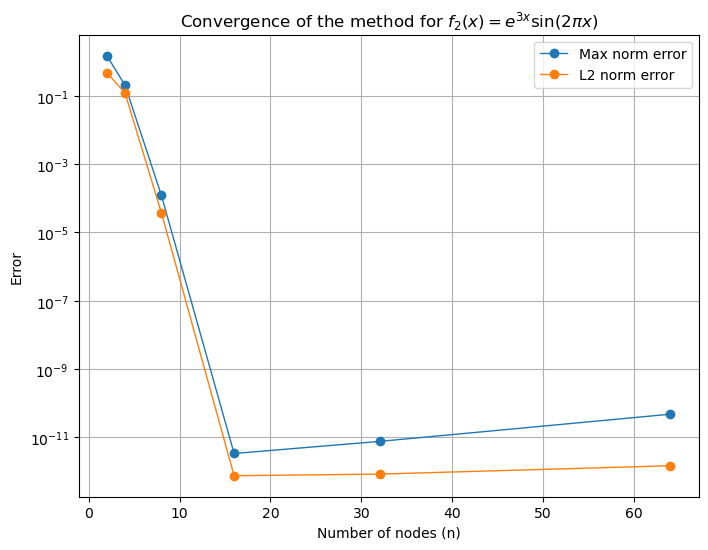

In [176]:
plt.semilogy(n_values, errors_f2[:, 0], 'o-', label='Max norm error')
plt.semilogy(n_values, errors_f2[:, 1], 'o-', label='L2 norm error')
plt.xlabel('Number of nodes (n)')
plt.ylabel('Error')
plt.title(r'Convergence of the method for $f_2(x) = e^{3x} \sin(2\pi x)$')
plt.legend()
plt.grid(True)
plt.show()

The figures show the empirical interpolation error in the $L^\infty$ and $L^2$ norms for $f_1(x)$ and $f_2(x)$ with $n\in\{2,4,8,16,32,64\}$. The error decreases rapidly up to $n=16$ (reaching about $10^{-11}$). For larger $n$ the curves level off and may increase slightly. This saturation is caused by numerical effects: evaluating the Lagrange basis (or solving for coefficients) in double precision is ill-conditioned, so roundoff dominates the true approximation error. Thus the plateau reflects computational limits rather than theory. Since the error is already below $10^{-11}$ by $n=16$, the interpolants have effectively converged at the plotted scales. For $f_1(x)$, the theoretical upper bound tracks the measured error closely for $n=2,4,8,16$, indicating that it is tight in this regime.

## Task c